In [3]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
epoch_num = 5
batch_size = 50
learning_rate = 5e-3

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
class_list = train_dataset.classes

torch.Size([50, 3, 32, 32]) torch.Size([50])


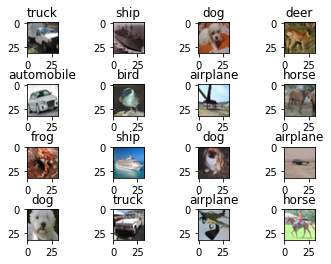

In [8]:
train_features, train_labels = next(iter(train_loader))
print(train_features.size(), train_labels.size())

fig, axs = plt.subplots(4, 4)
plt.subplots_adjust(wspace=0.1, hspace=1)
for i in range(16):
    img = torch.moveaxis(train_features[i], 0, 2)
    label = class_list[train_labels[i].item()]
    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].set_title(label)
plt.imshow(img)

In [13]:
class Conv(nn.Module):
    def __init__(self, class_num=10):
        super(Conv, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear = nn.Linear(8 * 8 * 32, class_num)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)

        return self.linear(out)


In [30]:
model = Conv(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
loss_list = []
with tqdm(total=epoch_num * len(train_loader), colour='CYAN', unit='batchs') as pbar:
    for e in range(epoch_num):
        for i, (pic, label) in enumerate(train_loader):
            pic = pic.to(device)
            label = label.to(device)
            output = model(pic)
            loss = criterion(output, label)
            if (i + 1) % 100 == 0:
                loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
torch.cuda.empty_cache()

100%|██████████| 5000/5000 [00:46<00:00, 106.90batchs/s]


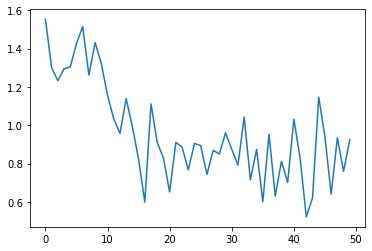

In [32]:
plt.plot(loss_list)

In [33]:
model.eval()

Conv(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)

In [34]:
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print(f'Accruacy: {correct / total}')

Accruacy: 0.6839
